In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
from quantnb.core.backtester import Backtester
from quantnb.strategies.S_base import S_base
from quantnb.lib import find_files, plotting
from quantnb.indicators import supertrend, SMA, cross_below, cross_above
from quantnb.helpers.S_calculate_metrics import calculate_dd
from quantnb.lib.output_trades import output_trades
from quantnb.lib import plotting

assets = find_files("./data", "quickswap")

datas = {}
for asset in assets:
    print(asset)
    df = pd.read_parquet(asset)
    df.rename(
        {"Open": "open", "High": "high", "Low": "low", "Close": "close"},
        axis=1,
        inplace=True,
    )
    datas[asset.split("/")[2]] = df

assets = find_files("./data", "uniswap_v2")

for asset in assets:
    print(asset)
    df = pd.read_parquet(asset)
    df.rename(
        {"Open": "open", "High": "high", "Low": "low", "Close": "close"},
        axis=1,
        inplace=True,
    )
    datas[asset.split("/")[2]] = df


assets = find_files("./data", "uniswap_v3-ethereum-WETH-USDC-1h")
# (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005) # Ether-USD Coin https://tradingstrategy.ai/trading-view/ethereum/uniswap-v3/eth-usdc-fee-5#30d


for asset in assets:
    print(asset)
    df = pd.read_parquet(asset)
    df.rename(
        {"Open": "open", "High": "high", "Low": "low", "Close": "close"},
        axis=1,
        inplace=True,
    )
    datas[asset.split("/")[2]] = df


assets = find_files("./data", "binance")

for asset in assets:
    datas[asset.split("-")[1]] = pd.read_parquet(asset)


keys = list(datas.keys())
keys

./data/quickswap_v3-polygon-WETH-USDC-1h.parquet
./data/uniswap_v2-ethereum-WETH-USDC-1h.parquet
./data/uniswap_v3-ethereum-WETH-USDC-1h-1h.parquet


['quickswap_v3-polygon-WETH-USDC-1h.parquet',
 'uniswap_v2-ethereum-WETH-USDC-1h.parquet',
 'uniswap_v3-ethereum-WETH-USDC-1h-1h.parquet',
 'ETHUSDT',
 'SOLUSDT',
 'DOTUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'UNIUSDT',
 'XRPUSDT',
 'DOGEUSDT',
 'BTCUSDT',
 'XLMUSDT',
 'LTCUSDT',
 'SHIBUSDT',
 'NEOUSDT',
 'TRXUSDT',
 'AVAXUSDT',
 'LINKUSDT',
 'ADAUSDT',
 'MATICUSDT']

In [2]:
class S_basket(S_base):
    def generate_signals(self, params=(10, 3, 200)):
        supert_period, supert_multiplier, sma_period = params
        df = self.data
        supert = supertrend(
            df.High.values,
            df.Low.values,
            df.Close.values,
            period=supert_period,
            multiplier=supert_multiplier,
        )[0]
        sma = SMA(df.Close.values, period=sma_period)

        self.supert = supert
        self.sma = sma
        a = cross_above(df.Close.values, supert)

        self.entries = np.logical_and(
            cross_above(df.Close.values, supert), df.Close.values > sma
        )
        self.exits = cross_below(df.Close.values, supert)

    def get_signals(self, params):
        self.generate_signals(params)

    def plot(self):
        data = self.data.copy()
        data.index = pd.to_datetime(data.index, unit="s")
        plotting.mpf_plot(
            data,
            [
                plotting.add_line_plot(self.supert, color="teal"),
                plotting.add_line_plot(self.equity, color="teal", panel=1),
                plotting.add_line_plot(self.sma, color="blue"),
                plotting.add_markers(self.entries, data, color="green"),
                plotting.add_markers(self.exits, data, color="red"),
            ],
        )


MAIN_OFFSET = 20000
print(f"Data length is {MAIN_OFFSET}")


def backtest(datas, key, offset, params):
    stats = pd.DataFrame()
    initial_capital = 10000
    # data = datas["ETHUSDT"]
    # data = data[49000:]

    # data[27468:]
    # data
    data = datas[key]
    # data = data[offset:]
    data = data[-MAIN_OFFSET:]

    st = S_basket(data, commission=0.0005, initial_capital=initial_capital)
    st.backtest(params)
    bt = st.bt

    trades = output_trades(st.bt, concatenate=False)
    print(len(trades))
    # print(st.stats)
    # print(data)
    return st


key = keys[0]
print("=======================================================", key)
backtest(datas, key, 0, (10, 3, 200))

print()
key = keys[1]
print("=======================================================", key)
backtest(datas, key, 3050, (10, 3, 200))


print()
key = keys[2]
print("=======================================================", key)
uni_bt = backtest(datas, key, 27448, (10, 3, 200))

print()
key = keys[3]
print("=======================================================", key)
bnb_bt = backtest(datas, key, 27448, (10, 3, 200))

Data length is 20000
======================================================= quickswap_v3-polygon-WETH-USDC-1h.parquet
174

======================================================= uniswap_v2-ethereum-WETH-USDC-1h.parquet
176

======================================================= ETHUSDT
121

======================================================= SOLUSDT
107


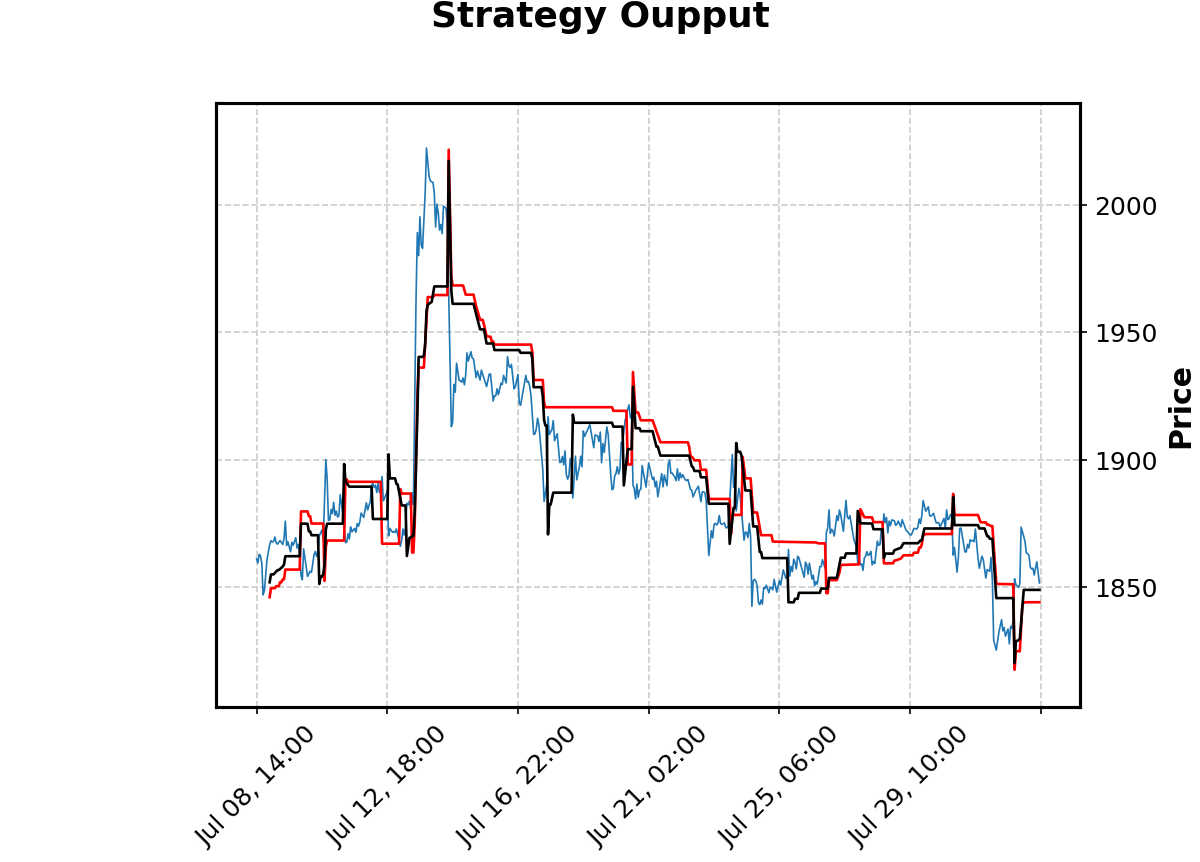

In [3]:
#
quick = datas[keys[0]][-MAIN_OFFSET:]
uni = datas[keys[1]][-MAIN_OFFSET:]
v3 = datas[keys[2]][-MAIN_OFFSET:]
bnb = datas[keys[3]][-MAIN_OFFSET:]
#
correlation_matrix = quick.corrwith(uni)

uni.corrwith(bnb)


df = pd.DataFrame(
    {
        "uni": uni.close.values,
        "bnb": bnb.close.values,
        "quick": quick.close.values,
        "v3": v3.close.values,
    }
)
df.tail()

# plotting.mpf_plot(quick, [])
plotting.mpf_plot(
    bnb,
    [
        plotting.add_line_plot(bnb_bt.supert, color="red"),
        # plotting.add_line_plot(bnb_bt.sma, color="red"),
        # plotting.add_line_plot(uni.close.values, color="gray"),
        plotting.add_line_plot(uni_bt.supert, color="black"),
        # plotting.add_line_plot(uni_bt.sma, color="orange"),
    ],
    type="line",
)
# plotting.mpf_plot(bnb, [])

In [4]:
INITIAL_CAPITAL = 1000 * 13
initial_capital = INITIAL_CAPITAL / len(datas.keys())
equities = []

for key in datas:
    data = datas[key]
    st = S_basket(data, commission=0.0005, initial_capital=initial_capital)
    st.backtest((10, 3, 200))
    df = pd.DataFrame(st.equity, index=data.index)
    equities.append(df)
    stats = pd.concat([stats, st.stats])
stats.index = datas.keys()


eq = pd.DataFrame()
for index, key in enumerate(datas):
    eq[key] = equities[index]
eq["sum"] = eq.sum(axis=1)

final_value = eq["sum"].iloc[-1]


total_return = ((final_value / INITIAL_CAPITAL) - 1) * 100
dd = calculate_dd(eq["sum"])
ratio = total_return / abs(dd)

stats = pd.DataFrame(
    {
        "initial_value": INITIAL_CAPITAL,
        "final_value": final_value,
        "dd": dd,
        "total_return": total_return,
        "ratio": ratio,
        # "buy_and_hold": buy_and_hold,
    },
    index=[0],
)
stats

# eq["sum"].plot()
# plt.show()w

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[27], line 8
      6     equities.append(df)
      7     stats = pd.concat([stats, st.stats])
----> 8 stats.index = datas.keys()
     10 stats
     12 eq = pd.DataFrame()

File ~/.cache/pypoetry/virtualenvs/quantnb-Z6CfztWv-py3.11/lib/python3.11/site-packages/pandas/core/generic.py:6002, in NDFrame.__setattr__(self, name, value)
   6000 try:
   6001     object.__getattribute__(self, name)
-> 6002     return object.__setattr__(self, name, value)
   6003 except AttributeError:
   6004     pass

File ~/.cache/pypoetry/virtualenvs/quantnb-Z6CfztWv-py3.11/lib/python3.11/site-packages/pandas/_libs/properties.pyx:69, in pandas._libs.properties.AxisProperty.__set__()

File ~/.cache/pypoetry/virtualenvs/quantnb-Z6CfztWv-py3.11/lib/python3.11/site-packages/pandas/core/generic.py:730, in NDFrame._set_axis(self, axis, labels)
    725 """
   